In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessiond

/kaggle/input/amazon-review-dataset/raw_data/Movies_and_TV_5.json
/kaggle/input/amazon-review-dataset/raw_data/Toys_and_Games_5.json
/kaggle/input/amazon-review-dataset/raw_data/Cell_Phones_and_Accessories_5.json
/kaggle/input/amazon-review-dataset/raw_data/All_Beauty_5.json
/kaggle/input/amazon-review-dataset/raw_data/Grocery_and_Gourmet_Food_5.json
/kaggle/input/amazon-review-dataset/raw_data/AMAZON_FASHION_5.json


# Installing Dependencies

In [2]:
%%capture
!pip install bertopic datasets accelerate bitsandbytes xformers adjustText

In [3]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.9 MB/s eta 0:00:00a 0:00:01


# Imports

In [4]:
import pandas as pd
import numpy as np
import re
import nltk
import spacy
from tqdm import tqdm
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import contractions
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

pd.options.display.max_colwidth = 100

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Json to Dataframe Creation

In [44]:
import os
import json
import pandas as pd

def json_to_df(folder_path, lines_to_read=10000):
    data_list = []

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            
            with open(file_path, "r") as file:
                for i, line in enumerate(file):
                    if i >= lines_to_read:
                        break

                    data = json.loads(line)
                    data_list.append(data)

    # Create a DataFrame from the list of JSON data
    df = pd.DataFrame(data_list)
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

In [45]:
folder_path = "/kaggle/input/amazon-review-dataset/raw_data"
df = json_to_df(folder_path=folder_path, lines_to_read=200000)

In [46]:
df.shape

(808445, 12)

# Data Cleaning and Text Data Preprocessing

In [47]:
# color coding
BLUE = '\033[94m'
GREEN = '\033[92m'
END = '\033[0m'

In [48]:
#------------------------------------------- Text Data Preprocessing -------------------------------------------------

# Remove missing reviews
print(f"{BLUE}No of missing reviews:{END} {df['reviewText'].isnull().sum()}")
df.dropna(subset=['reviewText'],inplace=True)
print(f"{BLUE}No of reviews after removing missing reviews:{END} {df['reviewText'].isnull().sum()}")
print(f"{GREEN}Missing reviews dropped{END}✅")


# Apply lower casing
df['reviewText'] = df['reviewText'].str.lower()
print(f"{GREEN}Converted to Lower case{END}✅")


# Remove html tags
def remove_html_tags(text):
    pattern = re.compile(r'<[^>]+>')
    modified_text = re.sub(pattern,'',text).strip()
    return modified_text
df['reviewText'] = df['reviewText'].apply(lambda x: remove_html_tags(x))
print(f"{GREEN}HTML tags removed{END}✅")


# Remove website url
def remove_website_url(text):
    # Define a regular expression pattern for identifying links
    link_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

    # Replace links with an empty string
    text_without_links = re.sub(link_pattern, '', text).strip()

    return text_without_links
df['reviewText'] = df['reviewText'].apply(lambda x: remove_website_url(x))
print(f"{GREEN}Website url removed{END}✅")


# Remove contractions
def remove_contractions(text):
    return contractions.fix(text)
df['reviewText'] = df['reviewText'].apply(lambda x: remove_contractions(x))
print(f"{GREEN}Contraction word removed{END}✅")


# Remove Punctuation and Special Character
def remove_special_characters_punctuations(sentence):
    pattern = re.compile("[^a-zA-Z]+") # match a single character not present in the set (basically anything other than a-z and A-Z)
    cleaned_text  = re.sub(pattern,' ',sentence).strip()
    return cleaned_text
df['reviewText'] = df['reviewText'].apply(lambda x: remove_special_characters_punctuations(x))
print(f"{GREEN}Punctuation and Special character removed{END}✅")


# Treat Consecutive repetative phrases
def replace_consecutive_repetitive_phrases(sentence):
    pattern = r'\b(\w+)(?:\s+\1\b)+'  # This pattern matches consecutive repetitive words
    cleaned_text = re.sub(pattern, r'\1', sentence, flags=re.IGNORECASE).strip()
    return cleaned_text
df['reviewText'] = df['reviewText'].apply(lambda x: replace_consecutive_repetitive_phrases(x))
print(f"{GREEN}Consequtive repeatative phrases treated{END}✅")


# Remove ChatWords in the document
chatwords_list = ["yeah","hahahahahahh", "wayy wayy",
                  "cos","brb", "OMG", "u","ur","gr8","nope",
                  "IMO", "IMHO", "LOL", "BTW", "FWIW",
                  "ICYMI", "YMMV", "OMG", "WOW", "FYI",
                  "TL;DR", "AFAIK", "BFF", "DIY", "N/A"
                 ]
def remove_chatwords(text, chatwords_list):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in chatwords_list]
    return ' '.join(filtered_tokens)
df['reviewText'] = df['reviewText'].apply(lambda x: remove_chatwords(x, chatwords_list))
print(f"{GREEN}Chatwords removed{END}✅")


# Apply Tokenization and Lemmatization
#def lemmatize_sentence(sentence):
#    lemmatizer = WordNetLemmatizer()
#    word_list = word_tokenize(sentence)
#    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
#    return lemmatized_output
#df['reviewText'] = df['reviewText'].apply(lambda x: lemmatize_sentence(x))
#print(f"{GREEN}Tokenization and Lemmatization applied{END}✅")


# Remove Stopwords
def remove_stopwords(text, custom_stopwords=None):
    # Tokenize the input text into words
    words = word_tokenize(text)
    
    # Get the list of English stopwords
    stop_words = set(stopwords.words('english'))
    
    # If custom stopwords are provided, add them to the stopwords set
    if custom_stopwords:
        stop_words = stop_words.union(custom_stopwords)
    # Remove stopwords from the list of words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Join the filtered words back into a sentence
    filtered_text = ' '.join(filtered_words)
    
    return filtered_text
# Adding custom stopwords
#custom_stopwords = {"much","however","sure","want","everything","even","think","thought","stay","find","something"
#                   ,"remove","either","keep","would","far","turn","also","yet","need","say"
#                   ,"can","around","seem","able","take","still","know","though","give","use","actually","bit"
#                   ,"since","wife","may","maybe","make","made","try","put","get","etc","doe","le","might","kind","gp","wa",
#                   "mean","going","alway","without","said","needed","g","go","getting","come","using","always","ha","nbsp"}
custom_stopwords = {"however","sure","want","everything","even","think","thought","stay","find","something"
                   ,"either","keep","would","far","turn","also","yet","need","say"
                   ,"can","around","seem","able","take","still","know","though","give","use","actually","bit"
                   ,"since","wife","make","made","try","put","get","etc","doe","le","might","kind","gp","wa",
                   "mean","going","alway","without","said","needed","g","go","getting","come","using","ha","nbsp"}
df['reviewText'] = df['reviewText'].apply(lambda x: remove_stopwords(text=x, custom_stopwords=custom_stopwords))
print(f"{GREEN}Stopwords removed{END}✅")

No of missing reviews: 298
No of reviews after removing missing reviews: 0
Missing reviews dropped✅
Converted to Lower case✅
HTML tags removed✅
Website url removed✅
Contraction word removed✅
Punctuation and Special character removed✅
Consequtive repeatative phrases treated✅
Chatwords removed✅
Stopwords removed✅


#### Login to huggingface account

In [49]:
from huggingface_hub import notebook_login
notebook_login()

##### We are using Llama2 7B parameter model

In [50]:
from torch import cuda

model_id = 'meta-llama/Llama-2-7b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


# Quantization

In [51]:
from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

In [52]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

# Create Text Generator

In [53]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

2024-02-17 18:02:57.573336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 18:02:57.573460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 18:02:57.790392: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [54]:
prompt = "Could you explain to me how 4-bit quantization works as if I am 5?"
res = generator(prompt)
print(res[0]["generated_text"])

Could you explain to me how 4-bit quantization works as if I am 5?
 everybody knows that 4 bits is not enough for most things, but it's a good starting point for understanding more complex quantization techniques.

For example, imagine you have a big jar of candy with different colors and shapes. Each piece of candy represents a number, like the number of apples in a tree or the number of cars on the road. You want to put all these candies into smaller jars so they don't take up too much space. But you can only fit so many candies in each jar before they start to get mixed up and lose their original numbers. That's kind of like what 4-bit quantization does!

So, let's say you have a really big number, like 100. You could try to write this number down using just 4 pieces of candy (like red, blue, green, and yellow). But there are so many ways you could arrange those candies to represent the number 100 that it would be hard to tell which one is right! That's because 4 bits isn't enough t

# Prompt Engineering

In [55]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

In [56]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

In [57]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

In [58]:
prompt = system_prompt + example_prompt + main_prompt

##### We are taking only 50000 reviews for model building

In [61]:
df['reviewText']

0         good quality durable months single complain htc phone charge placed vertically good buy samsung ...
1                                                                                              useful ir work
2                                    like cover much especially color always helps change things every awhile
3                                                                                                 works great
4         love rum cake usually scratch skeptical good figured saw friday sale one week much pleasant surp...
                                                         ...                                                 
808440                      love item hold phone utilize gps unit driving latch connects phone could sturdier
808441    yes big smartphone jogg ipod nano perfect deal comfortable running got galaxy note love ok every...
808442                                   good club becareful strap little loose otherwise bare necessity fits
808443    

In [63]:
df.reset_index(drop=True, inplace=True)

In [65]:
df['reviewText']

0         good quality durable months single complain htc phone charge placed vertically good buy samsung ...
1                                                                                              useful ir work
2                                    like cover much especially color always helps change things every awhile
3                                                                                                 works great
4         love rum cake usually scratch skeptical good figured saw friday sale one week much pleasant surp...
                                                         ...                                                 
808142                      love item hold phone utilize gps unit driving latch connects phone could sturdier
808143    yes big smartphone jogg ipod nano perfect deal comfortable running got galaxy note love ok every...
808144                                   good club becareful strap little loose otherwise bare necessity fits
808145    

In [69]:
df1 = df['reviewText'][:50000]

# Create Embeddings

In [70]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(df1, show_progress_bar=True)

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

# BerTopic Sub Model Creation

In [71]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [72]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

In [74]:
reduced_embeddings.shape

(50000, 2)

# Creating Representation model

In [75]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

# Apply BerTopic pipeline

In [77]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(df1, embeddings)

2024-02-17 18:13:27,801 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-17 18:14:41,705 - BERTopic - Dimensionality - Completed ✓
2024-02-17 18:14:41,707 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been us

# Showing the topic

In [78]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Llama2,MMR,Representative_Docs
0,-1,1513,-1_product_great_good_thank,"[product, great, good, thank, stuff, nice, works, classic, thanks, awesome]","[great, awesome, wonderful, excellent, thanks, happy, enjoy, product, cool, thank]","[Great Products, , , , , , , , , ]","[product, great, good, thank, stuff, nice, works, classic, thanks, awesome]","[great product, great product, great product]"
1,0,15929,0_old_great_toy_game,"[old, great, toy, game, loves, year, kids, play, fun, son]","[toys, toy, playing, play, kids, fun, children, played, loves, loved]","[Toy Recommendations for Kids, , , , , , , , , ]","[old, great, toy, game, loves, year, kids, play, fun, son]",[nice product good three year old gets pieces every definitely best older child nice set really ...
2,1,10746,1_movie_film_one_story,"[movie, film, one, story, dvd, good, time, great, movies, like]","[movie, good, movies, great, fun, excellent, comedy, watch, watched, film]","[Movies, , , , , , , , , ]","[movie, film, one, story, dvd, good, time, great, movies, like]","[good movie, good movie, good movie]"
3,2,10649,2_tea_taste_flavor_good,"[tea, taste, flavor, good, like, great, love, product, delicious, sugar]","[tea, teas, tasty, taste, tastes, yummy, delicious, drink, tasting, healthy]","[Tea Tastings, , , , , , , , , ]","[tea, taste, flavor, good, like, great, love, product, delicious, sugar]","[love tea taste excellent recommend, like tea, good tea]"
4,3,9035,3_phone_case_screen_iphone,"[phone, case, screen, iphone, battery, one, like, great, well, good]","[otterbox, phones, samsung, iphone, touch, purchased, phone, bought, protect, recommend]","[Phone Case Review, , , , , , , , , ]","[phone, case, screen, iphone, battery, one, like, great, well, good]",[case screen protector exactly described came tiny screen protector camera phone well protected ...
5,4,535,4_good_experience_valu_vety,"[good, experience, valu, vety, thse, ummm, uno, moive, nuff, mm]","[good, got, like, came, ever, intended, enough, one, honey, ummm]","[Good Experiences, , , , , , , , , ]","[good, experience, valu, vety, thse, ummm, uno, moive, nuff, mm]","[good, good, good]"
6,5,426,5_great_griffth_ole_downright,"[great, griffth, ole, downright, marvel, beat, supposed, okay, exactly, anything]","[great, good, okay, got, exactly, back, anything, like, supposed, downright]","[Greatness, , , , , , , , , ]","[great, griffth, ole, downright, marvel, beat, supposed, okay, exactly, anything]","[great, great, great]"
7,6,333,6_excellent_perfect_wonderful_super,"[excellent, perfect, wonderful, super, outstanding, excellente, fabulous, superbe, aaaaaaaaaa, v...","[excellent, superb, wonderful, terrific, great, outstanding, excellente, splendid, perfect, good]","[Excellent Topic, , , , , , , , , ]","[excellent, perfect, wonderful, super, outstanding, excellente, fabulous, superbe, aaaaaaaaaa, v...","[excellent, excellent, excellent]"
8,7,312,7_love_loves_god_gd,"[love, loves, god, gd, biblical, popeye, invented, whoever, enough, skeptical]","[love, loves, loving, soul, hope, god, feels, inspired, rest, bought]","[Love and its various interpretations, , , , , , , , , ]","[love, loves, god, gd, biblical, popeye, invented, whoever, enough, skeptical]","[love, love, love]"
9,8,189,8_movie_great_awesome_songs,"[movie, great, awesome, songs, really, madelynn, getaway, saddles, good, wonderful]","[movie, great, awesome, wonderful, excellent, fantastic, watch, enjoy, film, awsome]","[Movies, , , , , , , , , ]","[movie, great, awesome, songs, really, madelynn, getaway, saddles, good, wonderful]","[great movie, great movie, great movie]"


In [79]:
topic_model.get_topic(1, full=True)["KeyBERT"]

[('movie', 0.9221725),
 ('good', 0.91327643),
 ('movies', 0.9099768),
 ('great', 0.9003524),
 ('fun', 0.8998717),
 ('excellent', 0.8985124),
 ('comedy', 0.8935959),
 ('watch', 0.8903705),
 ('watched', 0.8897311),
 ('film', 0.88704133)]

In [80]:
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)

# Topic Visualization

In [83]:
summary = df['summary'][:50000]

In [84]:
topic_model.visualize_documents(summary, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

# Advanced Visualization

In [86]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in df1]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

In [87]:
df

,x,y,Topic,Length
1,9.236967,5.106575,0,14
7,4.570625,5.894783,2,11
8,7.679538,8.774903,0,242
9,8.288995,8.598178,0,16
10,-5.435584,6.759007,6,7
...,...,...,...,...
49982,8.874194,9.448246,0,51
49990,9.403211,5.961595,0,17
49994,8.432446,8.393936,0,51
49997,8.770924,7.092068,0,25


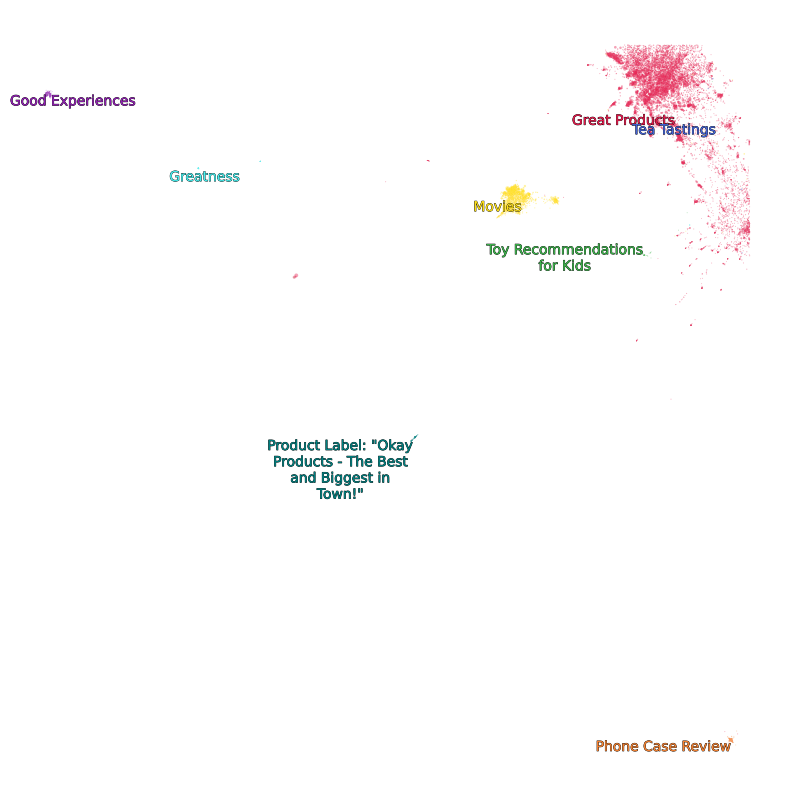

In [88]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe
import textwrap

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4, sizes=(0.4, 10), size="Length")

# Annotate top 50 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = textwrap.fill(topic_model.custom_labels_[int(topic)], 20)

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]
                          ))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.axis('off')
plt.legend('', frameon=False)
plt.show()

# Saving the assets

In [89]:
# To save: model, reduced embeddings, representative docs
!pip install safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [90]:
import pickle

with open('rep_docs.pickle', 'wb') as handle:
    pickle.dump(topic_model.representative_docs_, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('reduced_embeddings.pickle', 'wb') as handle:
    pickle.dump(reduced_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [91]:
embedding_model = "BAAI/bge-small-en"
topic_model.save("final", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [92]:
!zip -r /content/llama2.zip /content/final

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


	zip warning: name not matched: /content/final

zip error: Nothing to do! (try: zip -r /content/llama2.zip . -i /content/final)


In [93]:
!jupyter nbconvert --to markdown Topic_Modeling_with_Llama2.ipynb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] WARNING | pattern 'Topic_Modeling_with_Llama2.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
 